thinking...
thinking...

-----------------------------------------------
What Sensor Data Would You Like to Analysis?
1: Magentometer
2: Seismometer
x: Exit
-----------------------------------------------

Enter your choice (1-3): 1

------------------------------ A GUI icon shoud've appear in your task bar ------------------------------
---------------------- Select that to pick the data file you would like to analyze ----------------------


File selected: C:/Users/cacam/Downloads/mag_test.csv

---------------------------------------Close the GUI program window---------------------------------------
thinking...

Sample Rate: 5120
thinking...
thinking...
C:\Users\cacam\Documents\mag_data.csv

---------------------------------------
  === Magnetometer Analysis Menu ===
1: Plot Time Series
2: Plot FFT Spectrum
3: Plot Spectrogram
x: Return to main menu
-----------------------------------------

Enter your choice (1-4): 1


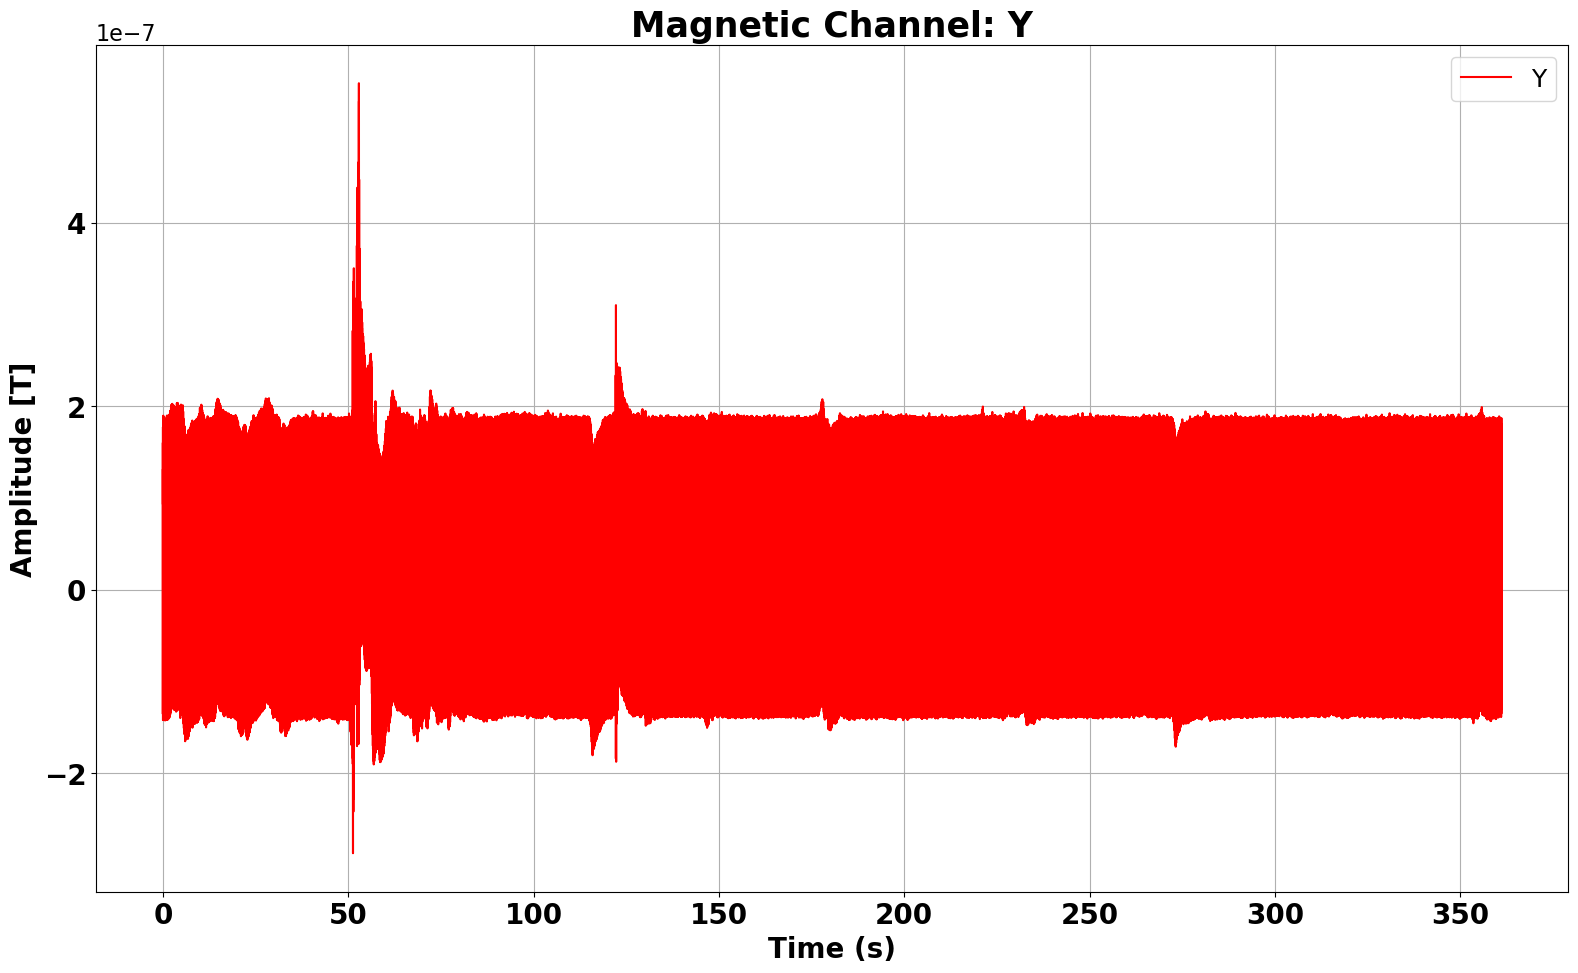

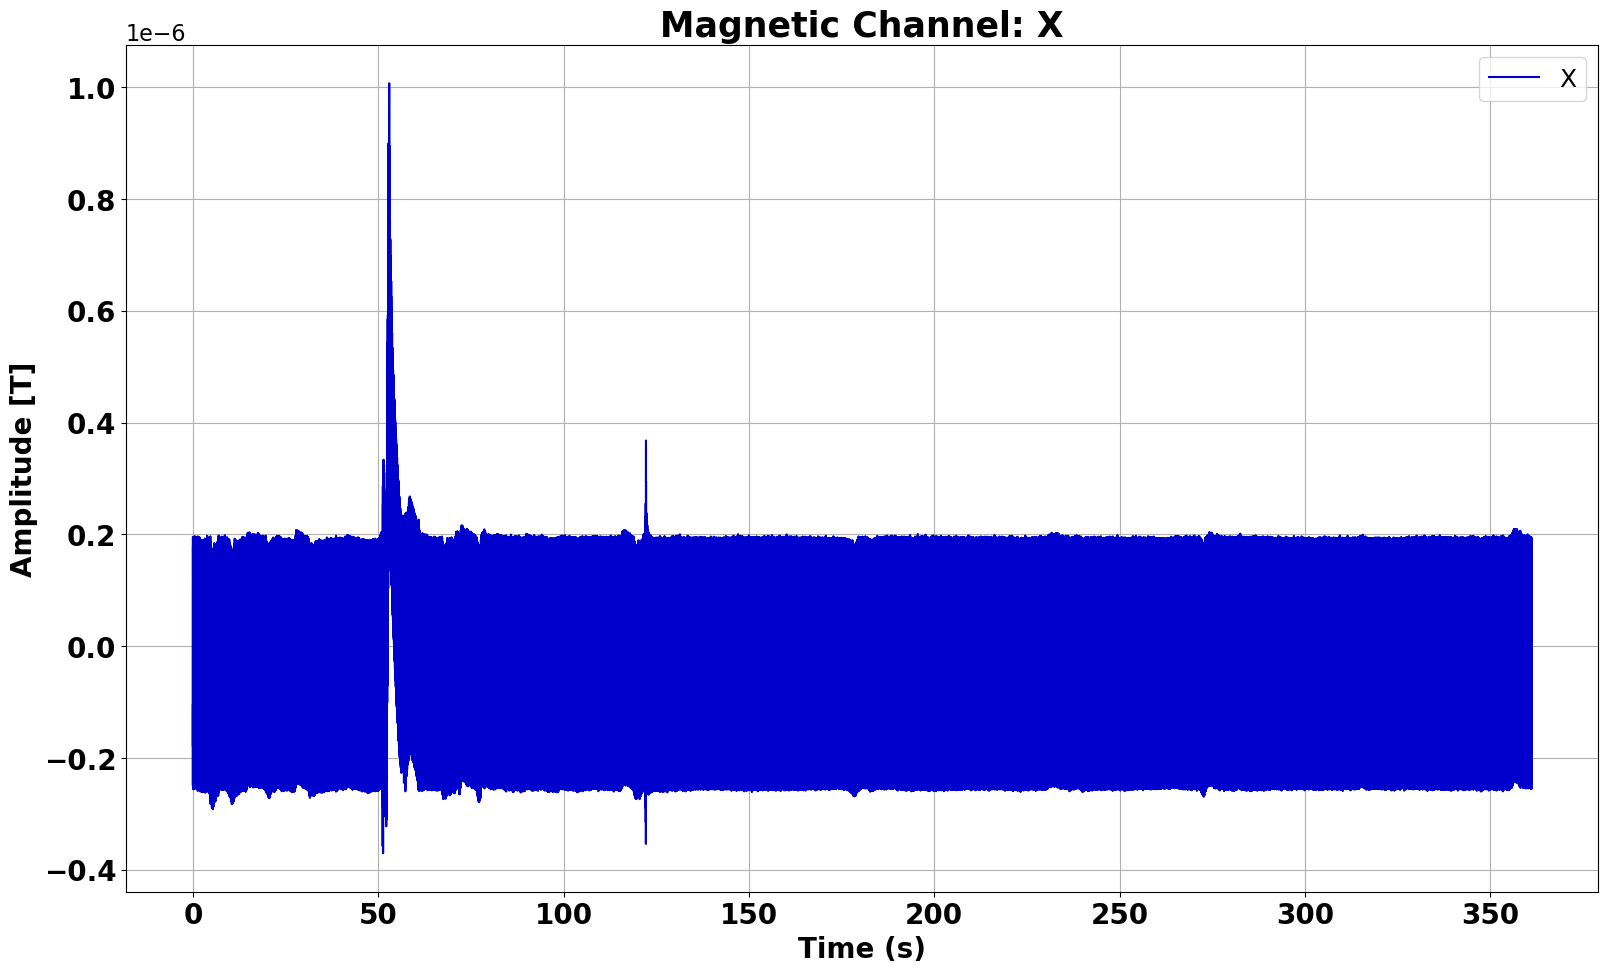

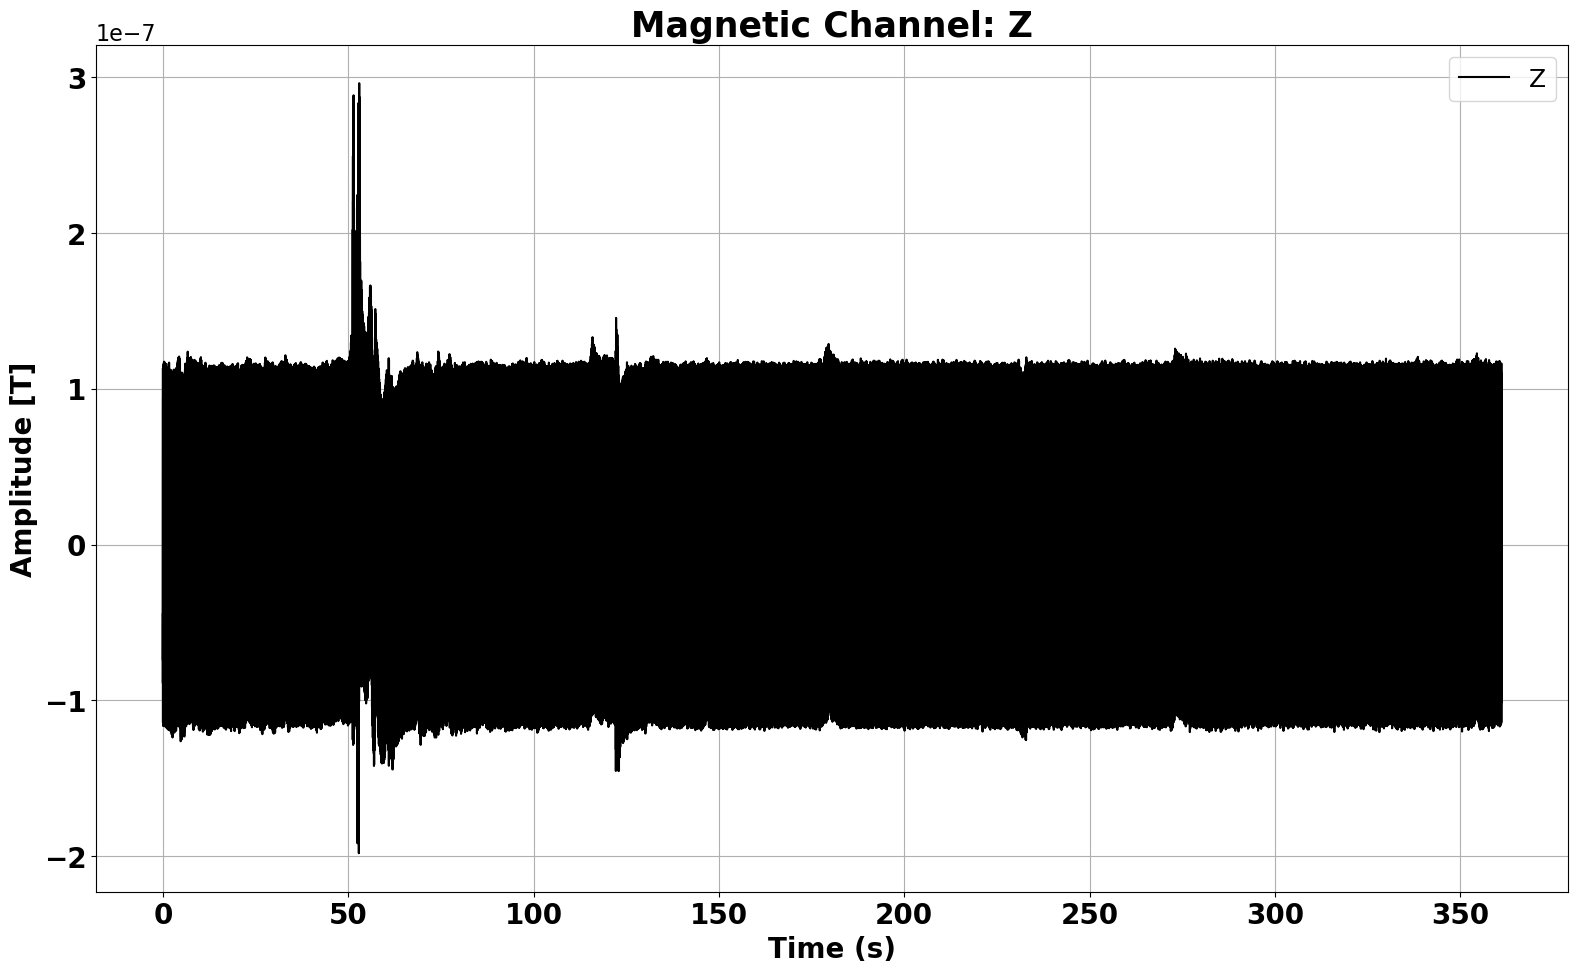


---------------------------------------
-- Time Series Options --
1: Zoom in on specific time range
x: Return to main menu
---------------------------------------

Enter your choice (1-3): 

Returning to main menu...

---------------------------------------
  === Magnetometer Analysis Menu ===
1: Plot Time Series
2: Plot FFT Spectrum
3: Plot Spectrogram
x: Return to main menu
-----------------------------------------

Enter your choice (1-4): 

Returning to main menu...

-----------------------------------------------
What Sensor Data Would You Like to Analysis?
1: Magentometer
2: Seismometer
x: Exit
-----------------------------------------------

Enter your choice (1-3): 

Exiting. Goodbye!


In [88]:
# print("thinking...")
import obspy
from obspy import UTCDateTime
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import numpy as np
print("thinking...")
from matplotlib import pyplot as plt
from ipywidgets import interact, IntSlider
print("thinking...")
from ipywidgets import FloatSlider
from ipywidgets import Layout 
from scipy import signal
from matplotlib import gridspec
from scipy.fft import fftshift
import warnings
import os


'''##########################################################################################################################'''
'''##########################################################################################################################'''

                                 ####  ######  #   #       #####  ###  #      #####  #####
                                #      #       #   #       #       #   #      #      #
                                #      ######  #   #       ###     #   #      ###    #####
                                #           #   # #        #       #   #      #          #
                                 ####  ######    #         #      ###  #####  #####  #####
                    
'''##########################################################################################################################'''
'''##########################################################################################################################'''
    
    
file_path_global = None

def csv_upload(function):
    
    print("\n------------------------------ A GUI icon shoud've appear in your task bar ------------------------------")
    print("---------------------- Select that to pick the data file you would like to analyze ----------------------\n")

    

    def upload_file():
        global file_path_global ## makes variable global 


        file_path_global = filedialog.askopenfilename(title="Select a file", filetypes=[("CSV Files", "*.csv")])

        print(f"\nFile selected: {file_path_global}")
        print("\n---------------------------------------Close the GUI program window---------------------------------------")

    root = tk.Tk() ## Create the program window
    root.title("Multi File Uploader")

    upload_button = tk.Button(root, text="Upload Sensor Data", command=upload_file) ## Create buttons for uploading files
    upload_button.pack(pady=15)

    root.mainloop() ## Runs the application
    
    print("thinking...")

#------------------------------------------------- Selects info from metadata -------------------------------------------------#

    metadata_rows = []
    metadata = {}

    with open(file_path_global, 'r') as f:
        for _ in range(5):
            metadata_rows.append(f.readline().strip()) 

    for row in metadata_rows:
        if ':' in row: 
            key, value = row.split(':', 1)
            metadata[key.strip()] = value.strip()


#-----------------------------------------# This is the sample rate from the metadata #----------------------------------------#

    sample_rate = float(metadata["Sample Rate"])
    print("\nSample Rate: " + metadata["Sample Rate"]) #------------ Prints out the sample rate as a sanity check -------------#

#------------------------------------------------------------------------------------------------------------------------------#

    print("thinking...")

    if function == "mag":
        columns = ["Sample", "Time (s)", "Noise (V)", "Voltage X (V)", "Voltage Y (V)", "Voltage Z (V)", "blank"]
        calibration = (1.222e-05)/21
        ctrl_calibration = (1.222e-05)/21
        control_file = 'mag_data.csv'
        
    elif function == "seis":
        columns = ["Sample", "Time (s)", "Noise (V)", "Channel E (V)", "Channel N (V)", "Channel Z (V)", "blank"]
        calibration = (0.0125e-1)/21
        ctrl_calibration = 0.0076e-6
        control_file = 'ligo_seis_data.txt'
        
    else:
        prin("oops")
    
#------------------------------------------------------------------------------------------------------------------------------#
    
    data = pd.read_csv(file_path_global, skiprows = 6, delimiter=',') 

    data.columns = columns

    time   = data[columns[1]]
    noise  = data[columns[2]] * calibration
    x_axis = data[columns[3]] * calibration # east
    y_axis = data[columns[4]] * calibration # north    
    z_axis = data[columns[5]] * calibration
    
#------------------------------------------------------------------------------------------------------------------------------#

    print("thinking...")
    
    script_dir = os.getcwd()
    control_data_path = os.path.join(script_dir, control_file)
    if os.path.exists(control_data_path):
        

        if control_file == 'ligo_seis_data.txt':
            huddle = pd.read_csv(control_data_path, delimiter="\s+")
            huddle.columns = ["frequency", "x", "y", "z"]

            ctrl_freq = huddle["frequency"]
            ctrl_x = huddle["x"] * ctrl_calibration
            ctrl_y = huddle["y"] * ctrl_calibration
            ctrl_z = huddle["z"] * ctrl_calibration
            
            return sample_rate, time, x_axis, y_axis, z_axis, ctrl_x, ctrl_y, ctrl_z, ctrl_freq

        elif control_file == 'mag_data.csv':
            print(control_data_path)

            ligo = pd.read_csv(control_data_path, delimiter=",", skiprows=5)
            #ligo.columns = ["Sample", "Time (s)", "Voltage X (V)", "Voltage Y (V)", "Voltage Z (V)"]
            

            ctrl_z = ligo['Voltage Z (V)'][0:647487] * calibration   
            ctrl_y = ligo['Voltage Y (V)'] * calibration
            ctrl_x = ligo['Voltage X (V)'] * ctrl_calibration
            ctrl_sr = 5120
            
            return sample_rate, time, x_axis, y_axis, z_axis, ctrl_x, ctrl_y, ctrl_z, ctrl_sr

    else:
        print("Control data not found\n")
        
    
'''##########################################################################################################################'''
'''##########################################################################################################################'''

                        #######  #####  #####  #####  ####        #####  ###  #      #####  #####
                        #  #  #  #      #      #      #   #       #       #   #      #      #
                        #  #  #  #####  ###    ###    #   #       ###     #   #      ###    #####
                        #  #  #      #  #      #      #   #       #       #   #      #          #
                        #     #  #####  #####  #####  ####        #      ###  #####  #####  #####

'''##########################################################################################################################'''
'''##########################################################################################################################'''

def mseed_upload(function):
    
    def get_valid_datetime(prompt):
        while True:
            date_input = input(prompt)
            try:
                return UTCDateTime(date_input)
            except Exception as e:
                print(f"Invalid date/time format: {e}")
                print("Please enter the date/time in the correct format (e.g., 2020-01-01T00:00:00)")
    
    print("\n------------------------------ A GUI icon shoud've appear in your task bar ------------------------------")
    print("---------------------- Select that to pick the data file you would like to analyze ----------------------\n")

    
    def upload_files():
        global file_paths_global 

        file_paths_global = filedialog.askopenfilenames(title="Select files", filetypes=[("All Files", "*.*")])

        if file_paths_global:
            for file_path in file_paths_global:
                print(f"File selected: {file_path}") 
            print("\nclose the program window")
        else:
            print("No files selected.")


    root = tk.Tk() ## Create the program window
    root.title("Multi File Uploader")

    upload_button = tk.Button(root, text="Upload Files", command=upload_files) ## Create buttons for uploading files
    upload_button.pack(pady=10)

    root.mainloop() ## Runs the application 

    paths = sorted(file_paths_global) ## sorts paths alphabetically and saves it to a variable   
    
    print("Enter the start and end times wish to look at")
    print("2020-01-01T00:00:00 This is the format it should be in")

    start_time = get_valid_datetime("Start date and time: ")
    end_time = get_valid_datetime("End date and time: ")
    
    start_time = UTCDateTime(start)
    end_time = UTCDateTime(end)  
    
    def process_multiple_miniseed(file_paths, start_time=None, end_time=None):
    
        sample_rates_all = []
        times_all = []       ## Variables for the function 
        data_values_all = []

        for idx, file_path in enumerate(file_paths):
            print(f"\nProcessing file {idx+1}: {file_path}")

            st = obspy.read(file_path) #---------------------------- Reads the MiniSEED file ----------------------------------#


            try:
                print(f"Filtering data between {start_time} and {end_time}")
                st = st.trim(starttime=start_time, endtime=end_time)
            except Exception as e:
                print(f"Error trimming data: {e}")
                continue      

            if len(st) == 0: ## Check if any traces remain after trimming
                print(f"No data available in the specified time range for file: {file_path}")
                continue

            sample_rates = []
            times = []         ## lists for the current file's trace(s) 
            data_values = []

#---------------------------------------- Process each remaining trace in the file --------------------------------------------#

            for trace in st:


                sample_rates.append(trace.stats.sampling_rate) #---------- Append trace data to lists for this file -----------#
                times.append(trace.times())                    #--------------# Relative times for each sample #---------------#
                data_values.append(trace.data)

            sample_rates_all.append(sample_rates)
            times_all.append(times)               ## Append the current file's trace data to the overall lists
            data_values_all.append(data_values)

#----------------------------------------------- Assigns variables for each file ----------------------------------------------#

        sample_rates1, sample_rates2, sample_rates3 = sample_rates_all
        times_e, times_n, times_z = times_all
        data_e, data_n, data_z = data_values_all

        return data_e, data_n, data_z, times_e, times_n, times_z, sample_rates1

#-------------------------------------------------------- Runs function -------------------------------------------------------#

    data_e, data_n, data_z, times_e, times_n, times_z, sr = process_multiple_miniseed(paths, start_time=start_time, 
                                                                                      end_time=end_time)
    
    time_e = times_e[0]
    time_n = times_e[0]
    time_z = times_z[0]
    
    z = data_z[0] * 0.0015e-6 #------------------- This the conversion factor for turning the data into m/s ------------------------#
    n = data_n[0] * 0.0015e-6 
    e = data_e[0] * 0.0015e-6


#-----------------------------------------# This is the sample rate from the metadata #----------------------------------------#

    sr =  sample_rates1[0]
    print("\nSample rate: " + str(sr))

#------------------------------------------------------------------------------------------------------------------------------#

    script_dir = os.getcwd()
    control_data_path = os.path.join(script_dir, 'ligo_seis_data.txt')

    if os.path.exists(control_data_path):
        huddle = pd.read_csv(control_data_path, delimiter="\s+")

        huddle.columns = ["frequency", "x", "y", "z"]

        hf = huddle["frequency"]
        hx = huddle["x"] * 0.0076e-6
        hy = huddle["y"] * 0.0076e-6 
        hz = huddle["z"] * 0.0076e-6

    else:
        print("LIGO data not found\n")
    
    return z, n, e, times_e, times_n, times_z, sr, hf, hx, hy, hz

    
'''##########################################################################################################################'''
'''##########################################################################################################################'''

    #   #   ###   ####   ###   ###   ####   #      #####       #####  #####  #      #####   ####  #####  ###   ###   ##    #
    #   #  #   #  #   #   #   #   #  #   #  #      #           #      #      #      #      #        #     #   #   #  # #   #
    #   #  #####  ####    #   #####  ####   #      ###         #####  ###    #      ###    #        #     #   #   #  #  #  #
     # #   #   #  #   #   #   #   #  #   #  #      #               #  #      #      #      #        #     #   #   #  #   # #
      #    #   #  #   #  ###  #   #  ####   #####  #####       #####  #####  #####  #####   ####    #    ###   ###   #    ##
    
'''##########################################################################################################################'''
'''##########################################################################################################################'''


def get_optional_float(prompt, func, ID, sensor, allow_back=True):

    while True:
        user_input = input(prompt).strip().lower()
        
        
#------------------------------------------------------------------------------------------------------------------------------#

        if func == "time_series":   
            if user_input in ["none", "", "default"]:
                return None
            if allow_back and user_input == "x":
                return "BACK"
            try:
                return float(user_input)
            except ValueError:
                print("Invalid input. Please enter a number, 'none', or 'x'.")        
            
#------------------------------------------------------------------------------------------------------------------------------#
            
        elif func == "asd":
            if ID == "fft_len":
                if user_input in ["none", "", "default"]:
                    if sensor == "seis":
                        return 128
                    elif sensor == "mag":
                        return 10                    
                if allow_back and user_input == "x":
                    return "BACK"
                try:
                    return float(user_input)
                except ValueError:
                    print("Invalid input. Please enter a number, 'none', 'default', or 'x'.")

            elif ID == "overlap": 
                if user_input in ["none", "", "default"]:
                    return 50
                if allow_back and user_input == "x":
                    return "BACK"
                try:
                    return float(user_input)
                except ValueError:
                    print("Invalid input. Please enter a number, 'none', 'default', or 'x'.")
                    
            elif ID == "my_max": 
                if user_input in ["", "default"]:
                    return 10e-7
                elif user_input in ["none"]:
                    return None
                if allow_back and user_input == "x":
                    return "BACK"
                try:
                    return float(user_input)
                except ValueError:
                    print("Invalid input. Please enter a number, 'none', 'default', or 'x'.")
                    
            elif ID == "my_min": 
                if user_input in ["", "default"]:
                    return 10e-14
                elif user_input in ["none"]:
                    return None
                if allow_back and user_input == "x":
                    return "BACK"
                try:
                    return float(user_input)
                except ValueError:
                    print("Invalid input. Please enter a number, 'none', 'default', or 'x'.")
                    
            elif ID == "y_max":
                if user_input in ["", "default"]:
                    if sensor == "seis":
                        return 10e-6
                    elif sensor == "mag":
                        return 10e-7
                elif user_input in ["none"]:
                    return None
                if allow_back and user_input == "x":
                    return "BACK"
                try:
                    return float(user_input)
                except ValueError:
                    print("Invalid input. Please enter a number, 'none', 'default', or 'x'.")
                    
            elif ID == "y_min": 
                if user_input in ["", "default"]:
                    if sensor == "seis":
                        return 50e-12
                    if sensor == "mag":
                        return 10e-13
                elif user_input in ["none"]:
                    return None
                if allow_back and user_input == "x":
                    return "BACK"
                try:
                    return float(user_input)
                except ValueError:
                    print("Invalid input. Please enter a number, 'none', 'default', or 'x'.")
                    
            elif ID == "x_max": 
                if user_input in ["", "default"]:
                    if sensor == "seis":
                        return 100
                    elif sensor == "mag":
                        return 2000
                elif user_input in ["none"]:
                    return None
                if allow_back and user_input == "x":
                    return "BACK"
                try:
                    return float(user_input)
                except ValueError:
                    print("Invalid input. Please enter a number, 'none', 'default', or 'x'.")
                    
            elif ID == "x_min": 
                if user_input in ["", "default"]:
                    if sensor == "seis":
                        return 0.1
                    elif sensor == "mag":
                        return 5e-2
                elif user_input in ["none"]:
                    return None
                if allow_back and user_input == "x":
                    return "BACK"
                try:
                    return float(user_input)
                except ValueError:
                    print("Invalid input. Please enter a number, 'none', 'default', or 'x'.")
                    
            elif ID == "prominence": 
                if user_input in ["", "default"]:
                    if sensor == "seis":
                        return 5
                    elif sensor == "mag":
                        return 2.25
                elif user_input in ["none"]:
                    return None
                if allow_back and user_input == "x":
                    return "BACK"
                try:
                    return float(user_input)
                except ValueError:
                    print("Invalid input. Please enter a number, 'none', 'default', or 'x'.")
                    
#------------------------------------------------------------------------------------------------------------------------------#

        elif func == "spectrogram":
    
            if ID == "fft_len":
                if user_input in ["none", "", "default"]:
                    return 10
                if allow_back and user_input == "x":
                    return "BACK"
                try:
                    return float(user_input)
                except ValueError:
                    print("Invalid input. Please enter a number, 'none', 'default', or 'x'.")
        
            elif ID == "overlap": 
                if user_input in ["none", "", "default"]:
                    return 50
                if allow_back and user_input == "x":
                    return "BACK"
                try:
                    return float(user_input)
                except ValueError:
                    print("Invalid input. Please enter a number, 'none', 'default', or 'x'.")
            
            elif ID == "y_max": 
                if user_input in ["", "default"]:
                    if sensor == "seis":
                        return 100
                    elif sensor == "mag":
                        return 200
                elif user_input in ["none"]:
                    return None
                if allow_back and user_input == "x":
                    return "BACK"
                try:
                    return float(user_input)
                except ValueError:
                    print("Invalid input. Please enter a number, 'none', 'default', or 'x'.")
                    
            elif ID == "y_min": 
                if user_input in ["none", "", "default"]:
                    return 0
                if allow_back and user_input == "x":
                    return "BACK"
                try:
                    return float(user_input)
                except ValueError:
                    print("Invalid input. Please enter a number, 'none', 'default', or 'x'.")
                    
            elif ID == "x_max": 
                if user_input in ["none", "", "default"]:
                    return None
                if allow_back and user_input == "x":
                    return "BACK"
                try:
                    return float(user_input)
                except ValueError:
                    print("Invalid input. Please enter a number, 'none', 'default', or 'x'.")
                    
            elif ID == "x_min": 
                if user_input in ["none","", "default"]:
                    return None
                if allow_back and user_input == "x":
                    return "BACK"
                try:
                    return float(user_input)
                except ValueError:
                    print("Invalid input. Please enter a number, 'none', 'default', or 'x'.")
                    
            elif ID == "c_min": 
                if user_input in ["", "default"]:
                    if sensor == "seis":
                        return 10e-10
                    elif sensor == "mag":
                        return 10e-14
                elif user_input in ["none"]:
                    return None
                if allow_back and user_input == "x":
                    return "BACK"
                try:
                    return float(user_input)
                except ValueError:
                    print("Invalid input. Please enter a number, 'none', 'default', or 'x'.")
                    
            elif ID == "c_max": 
                if user_input in ["", "default"]:
                    if sensor == "seis":
                        return 10e-9
                    elif sensor == "mag":
                        return 10e-10
                elif user_input in ["none"]:
                    return None
                if allow_back and user_input == "x":
                    return "BACK"
                try:
                    return float(user_input)
                except ValueError:
                    print("Invalid input. Please enter a number, 'none', 'default', or 'x'.")
                    
#------------------------------------------------------------------------------------------------------------------------------#

            else:
                print("Carlos didn't do his job properly")
    
    

'''##########################################################################################################################'''    
'''##########################################################################################################################'''

                              #####  #   #######   #####     #####  #####  ####    #  #####  #####
                                #    #   #  #  #   #         #      #      #   #   #  #      #    
                                #    #   #  #  #   ###       #####  ####   ####    #  ###    #####
                                #    #   #  #  #   #             #  #      #   #   #  #          #
                                #    #   #     #   #####     #####  #####  #   #   #  #####  #####

'''##########################################################################################################################'''
'''##########################################################################################################################'''


def plot_time_series(time, x, y, z, function):
    #print("Running time series plot...")
    
    def time_series(channels,t, zed, north, east, xmax, xmin, ymax, ymin, function):
        
        if function == "seis":
            title = "Seismic"
            labels = ['E', 'N', 'Z']
            y_label = "Amplitude (m/s)"
            
        elif function == "mag":
            title = "Magnetic"
            labels = ['X', 'Y', 'Z']
            y_label = "Amplitude [T]"
        
        plt.figure(figsize = (19, 11))
        ax = plt.gca()
        ax.yaxis.get_offset_text().set_fontsize(16)
            
        if channels == "1":
            plt.title(title + " Data Time Series", fontweight = 'bold', fontsize = 25)
            plt.plot(t, zed, linewidth = 1.5, color = 'black', label = labels[2]) 
            plt.plot(t, north, linewidth = 1.5, color = 'red', label = labels[1])
            plt.plot(t, east, linewidth = 1.5, color = 'mediumblue', label = labels[0])

        elif channels == "2":
            plt.title(title + " Channel: " + labels[1], fontweight = 'bold', fontsize = 25)
            plt.plot(t, north, linewidth = 1.5, color = 'red', label = labels[1])

        elif channels == "3":
            plt.title(title + " Channel: " + labels[0], fontweight = 'bold', fontsize = 25)
            plt.plot(t, east, linewidth = 1.5, color = 'mediumblue', label = labels[0])

        elif channels == "4":
            plt.title(title + " Channel: " + labels[2], fontweight = 'bold', fontsize = 25)
            plt.plot(t, zed, linewidth = 1.5, color = 'black', label = labels[2])

        plt.legend(loc = "upper right", fontsize = 18)
        plt.xlabel("Time (s)", fontweight = "bold", fontsize = 20)
        plt.ylabel(y_label, fontweight = "bold", fontsize = 20)

        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)

        plt.yticks(fontsize = 20, fontweight = "bold")
        plt.xticks(fontsize = 20, fontweight = "bold")
        plt.grid(True)
        plt.show()

    if function == "mag":
        time_series("2", time, z, y, x, None, None, None, None, function)
        time_series("3", time, z, y, x, None, None, None, None, function)
        time_series("4", time, z, y, x, None, None, None, None, function)
    
    elif function == "seis":
        time_series("1", time, z, y, x, None, None, None, None, function)
    
#------------------------------------------------------------------------------------------------------------------------------#

    while True:
        '''print("\n---------------------------------------")
        print("-- Time Series Options --")
        #print("1: Save plot to file")
        print("1: Zoom in on specific time range")
        print("x: Return to main menu")
        print("---------------------------------------")'''

        sub_choice = input("\n---------------------------------------\n-- Time Series Options --\n1: Zoom in on specific time range\nx: Return to main menu\n---------------------------------------\n\nEnter your choice (1-3): ")
        
        if sub_choice == "1":
            print("\nWhat x limits do you want (You can input None)")
            x_max = get_optional_float("Upper bound: ", "time_series", None, None)
            if x_max == "BACK":
                return
            
            x_min = get_optional_float("Lower bound: ", "time_series", None, None)
            if x_min == "BACK":
                return
            
            print("\nWhat y limits do you want (You can input None)")
            y_max = get_optional_float("Upper bound: ", "time_series", None, None)
            if y_max == "BACK":
                return
            
            y_min = get_optional_float("Lower bound: ", "time_series", None, None)
            if y_min == "BACK":
                return
                            
#------------------------------------------------------------------------------------------------------------------------------#

            while True:
        
                ''' This is what the menu will look like printed out. It iss done in one input line to ensure that the prompt 
                and input line are outputted together
                
                ---------------------------------------
                "Do you want all three channels or just one?
                "1: All three
                "2: North
                3: East
                4: Z
                x: Return to Time Series Options
                ---------------------------------------'''
                
                channel = input("\n\n---------------------------------------\nDo you want all three channels or just one?\n1: All three\n2: North\n3: East\n4: Z\nx: Return to Time Series Options\n---------------------------------------\n\nEnter your choice (1-5): ")

#------------------------------------------------------------------------------------------------------------------------------#

                if channel == "1": ## All Channels
                    if function == "mag":
                        time_series("2", time, z, y, x, x_max, x_min, y_max, y_min, function)
                        time_series("3", time, z, y, x, x_max, x_min, y_max, y_min, function)
                        time_series("4", time, z, y, x, x_max, x_min, y_max, y_min, function)

                    elif function == "seis":
                        time_series(channel, time, z, y, x, x_max, x_min, y_max, y_min, function)
                    

                elif channel == "2": ## N Channel
                    time_series(channel, time, z, y, x, x_max, x_min, y_max, y_min, function)
                    

                elif channel == "3": ## E Channel
                    time_series(channel, time, z, y, x, x_max, x_min, y_max, y_min, function)
                    

                elif channel == "4": ## Z Channel
                    time_series(channel, time, z, y, x, x_max, x_min, y_max, y_min, function)
                    

                elif channel == "x" or channel == "":
                    print("\nReturning to Time Series Options...")
                    break
                    
                else:
                    print("\nInvalid input. Try again.")
    
#------------------------------------------------------------------------------------------------------------------------------#
#------------------------------------------------------------------------------------------------------------------------------#

        elif sub_choice == "x" or sub_choice == "" or sub_choice == "2":
            print("\nReturning to main menu...")
            break
        else:
            print("\nInvalid input. Try again.")    
            
            
            
'''##########################################################################################################################'''            
'''##########################################################################################################################'''

                                   #####  ####   #####   ####  #####  ####    #    #  #######
                                   #      #   #  #      #        #    #   #   #    #  #  #  #
                                   #####  ####   ####   #        #    ####    #    #  #  #  #
                                       #  #      #      #        #    #   #   #    #  #  #  #
                                   #####  #      #####   ####    #    #   #    ####   #     #
                    
'''##########################################################################################################################'''
'''##########################################################################################################################'''


def plot_spectrum(sr, x, y, z, ligo_sr, ligo_x, ligo_y, ligo_z, function):
    print("Plotting Spectrum...")
    
#------------------------------------------------------------------------------------------------------------------------------#

    if function == "seis":
    
        ## X limits
        x_max = 100 ## in terms of frequency
        x_min = 0.1

        ## Velocity Y limits
        y_max = 10e-6 ## in terms of ms⁻¹/√Hz
        y_min = 50e-12  

        ## Displacement Y Limits
        my_max = 10e-7 ## in terms of m/√Hz
        my_min = 10e-14

        ## fft length
        fft_length = 128 ## in terms of seconds

        ## Precent FFT Overlap
        overlap = 50 ## 50% fft overlap
        
        ## Peak Promience
        prom = 5
        
        ## Plot labels
        v_title = "Seismic Velocity Data ASD"
        s_title = "Seismic Dispacement Data ASD"
        drctn_title = ["E Direction", "N Direction", "Z Direction"]
        v_label = "Amplitude [ms⁻¹/√Hz]"
        s_label = "Amplitude [m/√Hz]"

#------------------------------------------------------------------------------------------------------------------------------#

    elif function == "mag":
        
        ## Plot limits
        y_max = None#10e-8
        y_min = None#10e-13 

        x_max = 2000
        x_min = 0.01

        ## fft length
        fft_length = 10

        ## Precent FFT Overlap
        overlap = 50 # 50% fft overlap
        
        ## Peak Promience
        prom = 2
        
        ## Plot labels
        v_title = "Magnetic Data ASD"
        drctn_title = ["X Direction", "Y Direction", "Z Direction"]
        v_label = "Amplitude [T/√Hz]"
    
    
################################################################################################################################
#----------------------------------------- The PSD is calculated via welch from scipy -----------------------------------------#
#------------------------------------------------------------------------------------------------------------------------------#
################################################################################################################################

    warnings.simplefilter('ignore')
    
    
    def asd(data_z, data_n, data_e, sample_rate, lf, lx, ly, lz, bart_sample_rate, bart_x, bart_y, bart_z,
            over_lap, fft, signal_prom, ymin, ymax, xmin, xmax, func, channel):

#----------# If you don't want to look at the whole time series, you can add '1' to the variables, i.e z1, y1, x1 #------------#

        if data_z is not None:
            f_z, Pxx_den_z = signal.welch(data_z, sample_rate, window= 'hamming', 
                                          nperseg= (sample_rate *fft), noverlap= round(sample_rate *(over_lap *0.01)) )
        
            az = np.sqrt(Pxx_den_z)
            log_z = np.log(az)
            peak_z, _ = signal.find_peaks(log_z, 
                                      prominence = signal_prom)            
            mz = az / (2*np.pi *f_z)            
            
        if bart_z is not None:
            lf, amp_z = signal.welch(bart_z, bart_sample_rate, window= 'hamming', 
                                          nperseg= (bart_sample_rate *fft), noverlap= round(bart_sample_rate *(over_lap *0.01)))
            lz = np.sqrt(amp_z)
            
#------------------------------------------------------------------------------------------------------------------------------#

        if data_n is not None:
            f_n, Pxx_den_n = signal.welch(data_n, sample_rate, window= 'hamming', 
                                          nperseg= (sample_rate *fft), noverlap= round(sample_rate *(over_lap *0.01)) )
            
            an = np.sqrt(Pxx_den_n)
            log_n = np.log(an)
            peak_n, _ = signal.find_peaks(log_n, 
                                      prominence = signal_prom)
            mn = an / (2*np.pi *f_n)  
            
        if bart_y is not None:
            lf, amp_y = signal.welch(bart_y, bart_sample_rate, window= 'hamming', 
                                          nperseg= (bart_sample_rate *fft), noverlap= round(bart_sample_rate *(over_lap *0.01)))
            ly = np.sqrt(amp_y)
            #print(ly)
            #print(lf)
#------------------------------------------------------------------------------------------------------------------------------#

        if data_e is not None:
            f_e, Pxx_den_e = signal.welch(data_e, sample_rate, window= 'hamming', 
                                          nperseg= (sample_rate *fft), noverlap= round(sample_rate *(over_lap *0.01)) )
            ae = np.sqrt(Pxx_den_e)
            log_e = np.log(ae)
            peak_e, _ = signal.find_peaks(log_e, 
                                          prominence = signal_prom) 
            me = ae / (2*np.pi *f_e)
            
        if bart_x is not None:
            lf, amp_x = signal.welch(bart_x, bart_sample_rate, window= 'hamming', 
                                          nperseg= (bart_sample_rate *fft), noverlap= round(bart_sample_rate *(over_lap *0.01)))
            lx = np.sqrt(amp_x)

#------------------ nfft is how long the fft bin lengths, noverlap is bin overlap, window is the window used ------------------#
#---------------------- We used 100 sec bins, 0.5 sec overlap, and hamming window, these can be changed -----------------------#
#------------------------------------------------ # DO NOT CHANGE/REMOVE 'fs' # -----------------------------------------------#

#------------------------------------------------------ PLots Spectra ---------------------------------------------------------#

        plt.figure(figsize = (20, 8))

        plt.yscale('log')
        plt.xscale('log')

#------------------------------------------------------------------------------------------------------------------------------#
#------------------------------------------------------------------------------------------------------------------------------#

        if func == "velocity":
            
            #print(len(data_z))
            if data_z is not None:
                up = az
            if data_n is not None:
                north = an
            if data_e is not None:
                east = ae

            ylabel = v_label
            
        elif func == "displacement":
        
            if data_z is not None:
                up = mz
            if data_n is not None:
                north = mn
            if data_e is not None:
                east = me

            ylabel = s_label
            title = s_title
            
        else: 
            print("Carlos didn't do his job properly")
            
#------------------------------------------------------------------------------------------------------------------------------#
#------------------------------------------------------------------------------------------------------------------------------#
            
        if channel == "all":

            title = v_title

            plt.plot(f_z, up, color = 'black', linewidth = 1.75, label = drctn_title[2])
            plt.plot(f_n, north, color = 'red', linewidth = 1.75, label = drctn_title[1])
            plt.plot(f_e, east, color = 'mediumblue', linewidth = 1.75, label = drctn_title[0])

            plt.scatter(f_z[peak_z], up[peak_z], s = 100, color = 'limegreen', marker = 'x', 
                linewidths = 2.5, label = 'Signal Peaks')
            plt.scatter(f_n[peak_n], north[peak_n], s = 100, color = 'limegreen', marker = 'x', 
                        linewidths = 2.5)
            plt.scatter(f_e[peak_e], east[peak_e], s = 100, color = 'limegreen', marker = 'x', 
                        linewidths = 2.5)


        elif channel == "east":
            title = drctn_title[0]            
            plt.plot(f_e, east, color = 'mediumblue', linewidth = 1.75, label = 'E Direction', alpha = 0.5)
            plt.plot(lf, lx, color = "dimgrey", linewidth = 2, label = "LIGO Washington X", alpha = 0.5)


        elif channel == "north":
            title = drctn_title[1]
            plt.plot(f_n, north, color = 'red', linewidth = 1.75, label = 'N Direction', alpha = 0.5)
            plt.plot(lf, ly, color = "dimgrey", label = "LIGO Washington Y", alpha = 0.5)


        elif channel == "zed":
            #print(up)
            title = drctn_title[2]
            plt.plot(f_z, up, color = 'black', linewidth = 1.75, label = 'Z Direction', alpha = 0.5)
            plt.plot(lf, lz, color = "dimgrey", label = "LIGO Washington Z", alpha = 0.5)
            

#------------------------------------------------------------------------------------------------------------------------------#
#------------------------------------------------------------------------------------------------------------------------------#

        plt.legend(loc = "lower left", fontsize = 14.5, ncol = 2)

        plt.title('FFT: ' + str(fft) + "s", fontsize = 20, loc = "left",style ='italic')
        plt.title("Overlap: " + str(overlap) + "%", fontsize = 20, loc = "right",style ='italic')

        plt.title(title, fontweight = 'bold', fontsize = 25)

        plt.xlabel("Frequency [Hz]", fontweight = "bold", fontsize = 20)
        plt.ylabel(ylabel, fontweight = "bold", fontsize = 20)

        plt.yticks(fontsize = 20, fontweight = "bold")
        plt.xticks(fontsize = 20, fontweight = "bold")

        plt.ylim(ymin,ymax)
        plt.xlim(xmin,xmax)

        plt.grid(True, which="both", ls="-")
        plt.show()


#----------------------------------------------------- Plots Velocity ---------------------------------------------------------#
    asd(z, y, x, sr, None, None, None, None, None, None, None, None, 
        overlap, fft_length, prom, y_min, y_max, x_min, x_max, "velocity", "all")


#---------------------------------------------------- Plots Displacement ------------------------------------------------------#
    if function == "seis":
        asd(z, y, x, sr, None, None, None, None, None, None, None, None,
            overlap, fft_length, prom, my_min, my_max, x_min, x_max, "displacement", "all")

#------------------------------------------------------------------------------------------------------------------------------#
#------------------------------------------------------------------------------------------------------------------------------#
    
    while True:
        # In Jupyter the place of the input line is not consistent. So, sometimes it is printed out before the option list.
        # To fix this, the option list was placed into the input line, so that everything is alway together.
        
        # This is what the printed out option list will look like
        '''print("\n\n---------------------------------------")
        print("-- ASD Spectra Options --")
        print("1: Compare to LIGO Hanford Data")
        print("2: Change plot limits / FFT Parameters")
        print("x: Return to main menu")
        print("---------------------------------------")'''

        sub_choice = input("\n\n---------------------------------------\n-- ASD Spectra Options --\n1: Compare to LIGO Hanford Data\n2: Change plot limits / FFT Parameters\nx: Return to main menu\n---------------------------------------\n\nEnter your choice (1-3): ")
        
        if sub_choice == "1":
            
            if function == "seis":
            
                ## E Channel
                asd(None, None, x, sr, hf, hx, hy, hz, None, None, None, None,
                    overlap, fft_length, prom, y_min, y_max, x_min, x_max, "velocity", "east")

                ## N Channel
                asd(None, y, None, sr, hf, hx, hy, hz, None, None, None, None,
                    overlap, fft_length, prom, y_min, y_max, x_min, x_max, "velocity", "north")

                ## Z Channel
                
                asd(z, None, None, sr, hf, hx, hy, hz, None, None, None, None,
                    overlap, fft_length, prom, y_min, y_max, x_min, x_max, "velocity", "zed")
                
            elif function == "mag":
                
                ## -------------------------------- E Channel ---------------------------------- ##
                
                asd(None, None, x, sr, None, None, None, None, ligo_sr, ligo_x, None, None,
                    overlap, fft_length, prom, y_min, y_max, x_min, x_max, "velocity", "east")

                ## -------------------------------- N Channel ---------------------------------- ##
                
                asd(None, y, None, sr, None, None, None, None, ligo_sr, None, ligo_y, None,
                    overlap, fft_length, prom, y_min, y_max, x_min, x_max, "velocity", "north")

                ## -------------------------------- Z Channel ---------------------------------- ##

                asd(z, None, None, sr, None, None, None, None, ligo_sr, None, None, ligo_z,
                    overlap, fft_length, prom, y_min, y_max, x_min, x_max, "velocity", "zed")
        
#------------------------------------------------------------------------------------------------------------------------------#            

        elif sub_choice == "2":
            
            print("\nWhat x limits do you want (You can input None)")
            x_max = get_optional_float("Upper bound: ", "asd", "x_max", function)
            if x_max == "BACK":
                return
            
            x_min = get_optional_float("Lower bound: ", "asd", "x_min", function)
            if x_min == "BACK":
                return
                        
#------------------------------------------------------------------------------------------------------------------------------#

            print("\nWhat y limits do you want for the velocity plot? (You can input None or default)")
            y_max = get_optional_float("Upper bound: ", "asd", "y_max", function)
            if y_max == "BACK":
                return
            
            y_min = get_optional_float("Lower bound: ", "asd", "y_min", function)
            if y_min == "BACK":
                return
                
            if function == "seis":
                print("\nWhat y limits do you want for the displacement plot? (You can input None or Default)")
                my_max = get_optional_float("Upper bound: ", "asd", "my_max", function)
                if my_max == "BACK":
                    return

                my_min = get_optional_float("Lower bound: ", "asd", "my_min", function)
                if my_min == "BACK":
                    return
            
#------------------------------------------------------------------------------------------------------------------------------#            
  
            print("\nHow long do you want the FFTs to be? (You can input None)")
            fft_length = get_optional_float("FFT length [s]: ", "asd", "fft_len", function)
            if fft_length == "BACK":
                return
            
            print("\nHow much FFT overlap do you want? i.e 50 for 50%")
            overlap = get_optional_float("Overlap Percentage: ", "asd", "overlap", function)
            if overlap == "BACK":
                return
            
            print("\nWhat prominence level do you want for peaks? (Default is 5)")
            prom = get_optional_float("Prominence level: ", "asd", "prominence", function)
            if prom == "BACK":
                return
                
#----------------------------------------------------- Plots Velocity ---------------------------------------------------------#
    
            asd(z, y, x, sr, None, None, None, None, None, None, None, None,
                overlap, fft_length, prom, y_min, y_max, x_min, x_max, "velocity", "all")


#---------------------------------------------------- Plots Displacement ------------------------------------------------------#
            if function == "seis":
                asd(z, y, x, sr, None, None, None, None, None, None, None, None, 
                    overlap, fft_length, prom, my_min, my_max, x_min, x_max, "displacement", "all")

#------------------------------------------------------------------------------------------------------------------------------#
#------------------------------------------------------------------------------------------------------------------------------#
    
        elif sub_choice == "x" or sub_choice == "" or sub_choice == "3":
            print("\nReturning to main menu...")
            break
        else:
            print("\nInvalid input. Try again.") 


            
'''##########################################################################################################################'''
'''##########################################################################################################################'''

                        #####  ####   #####   ####  #####  ####    ###    ###   ####    ####   #######
                        #      #   #  #      #        #    #   #  #   #  #      #   #  #    #  #  #  #
                        #####  ####   ####   #        #    ####   #   #  #  ##  ####   ######  #  #  #
                            #  #      #      #        #    #   #  #   #  #   #  #   #  #    #  #  #  #
                        #####  #      #####   ####    #    #   #   ###    ###   #   #  #    #  #     #
                    
'''##########################################################################################################################'''
'''##########################################################################################################################'''



def plot_spectrogram(sr,x, y, z, function):
    print("\nPlotting Spectrogram...\n\nThis may take a while")
    
#------------------------------------------------------------------------------------------------------------------------------#

    if function == "seis":    

        ## Colorbar Limits
        cmin = 10e-10
        cmax = 10e-9

        ## Plot limits
        y_max = 100 ## In terms of frequency
        y_min = 0

        ## fft length 
        fft_len = 10 ## in terms of seconds

        ## Precent FFT Overlap
        overlap = 50 ## 50% fft overlap

#------------------------------------------------------------------------------------------------------------------------------#

    if function == "mag":
        
        ## Colorbar Limits
        cmin = 10e-14
        cmax = 10e-10

        ## Plot limits
        y_max = 200 ## In terms of frequency
        y_min = 0

        ## fft length 
        fft_len = 10 ## in terms of seconds

        ## Precent FFT Overlap 
        overlap = 50 ## 50% fft overlap
    
#------------------------------------------------------------------------------------------------------------------------------#
    
    
    
################################################################################################################################
#----------------------------# The spectrograms are calculated with signal.spectrogram from SciPy #----------------------------#
#------------------------------------------------------------------------------------------------------------------------------#


    def spectrogram(data, channel, sample_rate, over_lap, fft, c_min, c_max, ymin, ymax, xmin, xmax, function):
        warnings.simplefilter('ignore')

        f, t, Sxx = signal.spectrogram(data, sample_rate, window= 'hamming'
                                          , nperseg=round(sample_rate * fft), noverlap= round(sample_rate *(over_lap *0.01)) )

#------------------------------------------------------------------------------------------------------------------------------#

        if function == "seis":
            cbar_units = 'Intensity [ms⁻¹/√Hz]'
            
            if channel == "z":
                title = "Z Direction"
            elif channel == "x":
                title = "E Direction"
            elif channel == "y":
                title = "N Direction"
            else:
                print("Carlos didn't do his job properly")

        elif function == "mag":
            cbar_units = 'Intensity [T/$\sqrt{Hz}$]'
            
            if channel == "z":
                title = "Z Direction"
            elif channel == "x":
                title = "X Direction"
            elif channel == "y":
                title = "Y Direction"
            else:
                print("Carlos didn't do his job properly")
                
#------------------------------------------------------------------------------------------------------------------------------#

        fig = plt.figure(figsize = (20,8))

        gs = gridspec.GridSpec(1,1)

        axis1 = fig.add_subplot(gs[0,0])

        m0 = axis1.pcolormesh(t, f, np.sqrt(Sxx), shading='gouraud', vmin = c_min, vmax = c_max)

        axis1.set_title('FFT: ' + str(fft) + "s", fontsize = 15, loc = "left",style ='italic')
        axis1.set_title("Overlap: " + str(over_lap) + "%", fontsize = 15, loc = "right",style ='italic')

        axis1.set_title(title, fontweight = 'bold' , fontsize = 25)
        axis1.set_xlabel('Time [s]', fontweight = 'bold' , fontsize = 20)
        axis1.set_ylabel('Frequency [Hz]', fontweight = 'bold' , fontsize = 20)
        axis1.tick_params(labelsize=16)

        cbar0 = fig.colorbar(m0, pad =0.02)
        cbar0.ax.tick_params(labelsize=16)
        cbar0.set_label(label= cbar_units ,weight='bold', fontsize = 16)
        cbar0.ax.yaxis.offsetText.set_fontsize(14)

        axis1.set_ylim(ymin,ymax) ## Uncomment to set limits
        axis1.set_xlim(xmin,xmax)
        plt.show()


#---------------------------------------------------------- E Channel ---------------------------------------------------------#
    spectrogram(x, "x", sr, overlap, fft_len, cmin, cmax, y_min, y_max, None, None, function)
    
#---------------------------------------------------------- N Channel ---------------------------------------------------------#
    spectrogram(y, "y", sr, overlap, fft_len, cmin, cmax, y_min, y_max, None, None, function)
    
#---------------------------------------------------------- Z Channel ---------------------------------------------------------#
    spectrogram(z, "z", sr, overlap, fft_len, cmin, cmax, y_min, y_max, None, None, function)

    
################################################################################################################################
#------------------------------------------------------------------------------------------------------------------------------#    
    
    while True:
        '''print("\n---------------------------------------")
        print("-- Spectrogram Options --")
        #print("1: Save plot to file")
        print("1: Change plot limits / FFT Parameters")
        print("x: Return to main menu")
        print("---------------------------------------")'''

        sub_choice = input("\n---------------------------------------\n-- Spectrogram Options --\n1: Change plot limits / FFT Parameters\nx: Return to main menu\n---------------------------------------\n\nEnter your choice (1-2): ")
        
#------------------------------------------------------------------------------------------------------------------------------#            

        if sub_choice == "1":
            
            print("\nWhat x limits do you want (You can input None)")
            x_max = get_optional_float("Upper bound: ", "spectrogram", "x_max", function)
            if x_max == "BACK":
                return
            
            x_min = get_optional_float("Lower bound: ", "spectrogram", "x_min", function)
            if x_min == "BACK":
                return

            print("\nWhat y limits do you want for the velocity plot? (You can input None or default)")
            y_max = get_optional_float("Upper bound: ", "spectrogram", "y_max", function)
            if y_max == "BACK":
                return
            
            y_min = get_optional_float("Lower bound: ", "spectrogram", "y_min", function)
            if y_min == "BACK":
                return
            
#------------------------------------------------------------------------------------------------------------------------------#
                
            print("\nWhat intensity limits do you want for the plot? (You can input None or Default)")
            cmax = get_optional_float("Upper bound: ", "spectrogram", "c_max", function)
            if cmax == "BACK":
                return
            
            cmin = get_optional_float("Lower bound: ", "spectrogram", "c_min", function)
            if cmin == "BACK":
                return
            
#------------------------------------------------------------------------------------------------------------------------------#            
  
            print("\nHow long do you want the FFTs to be? (You can input None)")
            fft_len = get_optional_float("FFT length [s]: ", "spectrogram", "fft_len", function)
            if fft_len == "BACK":
                return
            
            print("\nHow much FFT overlap do you want? i.e 50 for 50%")
            overlap = get_optional_float("Overlap Percentage: ", "spectrogram", "overlap", function)
            if overlap == "BACK":
                return
            
            print("Replotting Spectrogram...\n\nThis may take a while")
            
            
#---------------------------------------------------------- E Channel ---------------------------------------------------------#
            spectrogram(x, "x", sr, overlap, fft_len, cmin, cmax, y_min, y_max, x_min, x_max, function)
    
#---------------------------------------------------------- N Channel ---------------------------------------------------------#
            spectrogram(y, "y", sr, overlap, fft_len, cmin, cmax, y_min, y_max, x_min, x_max, function)
    
#---------------------------------------------------------- Z Channel ---------------------------------------------------------#
            spectrogram(z, "z", sr, overlap, fft_len,  cmin, cmax, y_min, y_max, x_min, x_max, function)

    
#------------------------------------------------------------------------------------------------------------------------------#
#------------------------------------------------------------------------------------------------------------------------------#

        elif sub_choice == "x" or sub_choice == "":
            print("\nReturning to main menu...")
            break
        else:
            print("\nInvalid input. Try again.")

    
'''##########################################################################################################################'''
'''##########################################################################################################################'''

                                #######   ###   #  ##    #    #######  #####  ##     #  #    #
                                #  #  #  #   #     # #   #    #  #  #  #      #  #   #  #    #
                                #  #  #  #####  #  #  #  #    #  #  #  ####   #   #  #  #    #
                                #  #  #  #   #  #  #   # #    #  #  #  #      #    # #  #    #
                                #     #  #   #  #  #    ##    #     #  #####  #     ##   ####

'''##########################################################################################################################'''
'''##########################################################################################################################'''


def main_menu():
    while True:
        print("\n-----------------------------------------------")
        print("What Sensor Data Would You Like to Analysis?")
        print("1: Magentometer")
        print("2: Seismometer")
        print("x: Exit")
        print("-----------------------------------------------")
        
        choice = input("\nEnter your choice (1-3): ").strip().lower()
        
#------------------------------------------------------------------------------------------------------------------------------#
        
        if choice == "1":
            
            function = "mag"
            
            sr, time, x, y, z, ligo_x, ligo_y, ligo_z, ligo_sr = csv_upload(function)
            
            #print(len(ligo_z))
            #print(ligo_sr)
            
            while True:
                print("\n---------------------------------------")
                print("  === Magnetometer Analysis Menu ===")
                print("1: Plot Time Series")
                print("2: Plot FFT Spectrum")
                print("3: Plot Spectrogram")
                print("x: Return to main menu")
                print("---------------------------------------")

                sub_choice = input("\nEnter your choice (1-4): ").strip().lower()

                if sub_choice == "1":
                    plot_time_series(time, x, y, z, function)
                    
                elif sub_choice == "2":
                    plot_spectrum(sr, x, y, z, ligo_sr, ligo_x, ligo_y, ligo_z, function)
                    
                elif sub_choice == "3":
                    plot_spectrogram(sr, x, y, z, function)

                elif sub_choice == "x" or sub_choice == "":
                    print("\nReturning to main menu...")
                    break
                    
                else:
                    print("\nInvalid input. Try again.")
                    
                    
################################################################################################################################
#------------------------------------------------------------------------------------------------------------------------------#
################################################################################################################################


        elif choice == "2":
            while True:
                print("\n---------------------------------------")
                print("        === Seismometer Menu ===\n")
                print("1: WebDAQ Analysis")
                print("2: Minimus Analysis")
                print("x: Return to main menu")
                print("-----------------------------------------")
                
                sub_choice = input("\nEnter your choice (1-4): ").strip().lower()

                if sub_choice == "1":
                    
                    function = "seis"
                    #         e, n, z
                    sr, time, x, y, z, ligo_x, ligo_y, ligo_z, ligo_freq = csv_upload(function)
                    
                    while True:
                        print("\n---------------------------------------")
                        print("    === Seismometer Analysis Menu ===")
                        print("1: Plot Time Series")
                        print("2: Plot FFT Spectrum")
                        print("3: Plot Spectrogram")
                        print("x: Return to main menu")
                        print("-----------------------------------------")

                        sub_choice = input("\nEnter your choice (1-4): ").strip().lower()

                        if sub_choice == "1":
                            plot_time_series()

                        elif sub_choice == "2":
                            plot_spectrum()

                        elif sub_choice == "3":
                            plot_spectrogram()

                        elif sub_choice == "x" or sub_choice == "":
                            print("\nReturning to main menu...")
                            break

                        else:
                            print("\nInvalid input. Try again.")
                    
                elif sub_choice == "2":
                    print("Not yet")

                elif sub_choice == "x" or sub_choice == "":
                    print("\nReturning to main menu...")
                    break
                else:
                    print("\nInvalid input. Try again.")
            
        elif choice == "x" or  choice =="":
            print("\nExiting. Goodbye!")
            break
            
        else:
            print("\nInvalid input. Please choose 1, 2, x.")

if __name__ == "__main__":
    main_menu()


In [ ]:
'''def main_menu():
    while True:
        print("\n---------------------------------------")
        print("      === Data Analysis Menu ===")
        print("         1: Plot Time Series")
        print("         2: Plot FFT Spectrum")
        print("         3: Plot Spectrogram")
        print("         x: Exit")
        print("---------------------------------------")

        choice = input("\nEnter your choice (1-4): ").strip().lower()

        if choice == "1":
            plot_time_series()
        elif choice == "2":
            plot_spectrum()
        elif choice == "3":
            plot_spectrogram()
        elif choice == "x" or  choice =="":
            print("\nExiting. Goodbye!")
            break
        else:
            print("\nInvalid input. Please choose a number between 1 and 4.")

if __name__ == "__main__":
    main_menu()'''



'''
#------------------------------------------------------------------------------------------------------------------------------#
#------------------------------------------------------------------------------------------------------------------------------#

        if sub_choice == "1":
            print("\nWhat you do you want to save the plot as?")
            print("No spaces or invalid chacaters (#, %, &, {, }, $, !, ', +, \``, =, *, :, <, >, ?, /, \, |)")
            name = input("plot name: ")

            print("\nWhat format would you like?")
            print("png, jpg, jpeg, pdf")
            Format = input("plot format: ")

            plt.savefig(str(name) + '.' + str(Format), bbox_inches='tight')
            print("The image has been saved to this directory (☆•ヮ•)八(•ヮ•)")


#------------------------------------------------------------------------------------------------------------------------------#
#------------------------------------------------------------------------------------------------------------------------------#
'''